# FINAL PROJECT

This project aims to track the spread of Brown Marmorated Stink Bug (BMSB) populations in Minnesota. To achieve this, three Huff models with varying alpha values (1.5, 1.75, and 2) are utilized to simulate the spread of BMSB from a seed city. The objective is to rank cities based on the prevalence of BMSB.

The simulation process involves analyzing true negative, true positive, false negative, and false positive values. These metrics are crucial for assessing the quality of the models. Subsequently, a ranking of the models is created based on their performance.

To make the results accessible and actionable, they are exposed via an API for integration into the ArcGIS Online Map Viewer. This integration allows stakeholders to visualize and interact with the BMSB spread data, enabling informed decision-making regarding pest management strategies and resource allocation.

**Huff Model**

**What Esri Says:**
The Huff Model, also known as the Huff gravity model, is an established theory in spatial analysis. It is based on the principle that the probability of a given consumer visiting and purchasing at a given site is a function of the distance to that site, its attractiveness, and the distance and attractiveness of competing sites.

Link: https://pro.arcgis.com/en/pro-app/latest/tool-reference/business-analyst/understanding-huff-model.htm

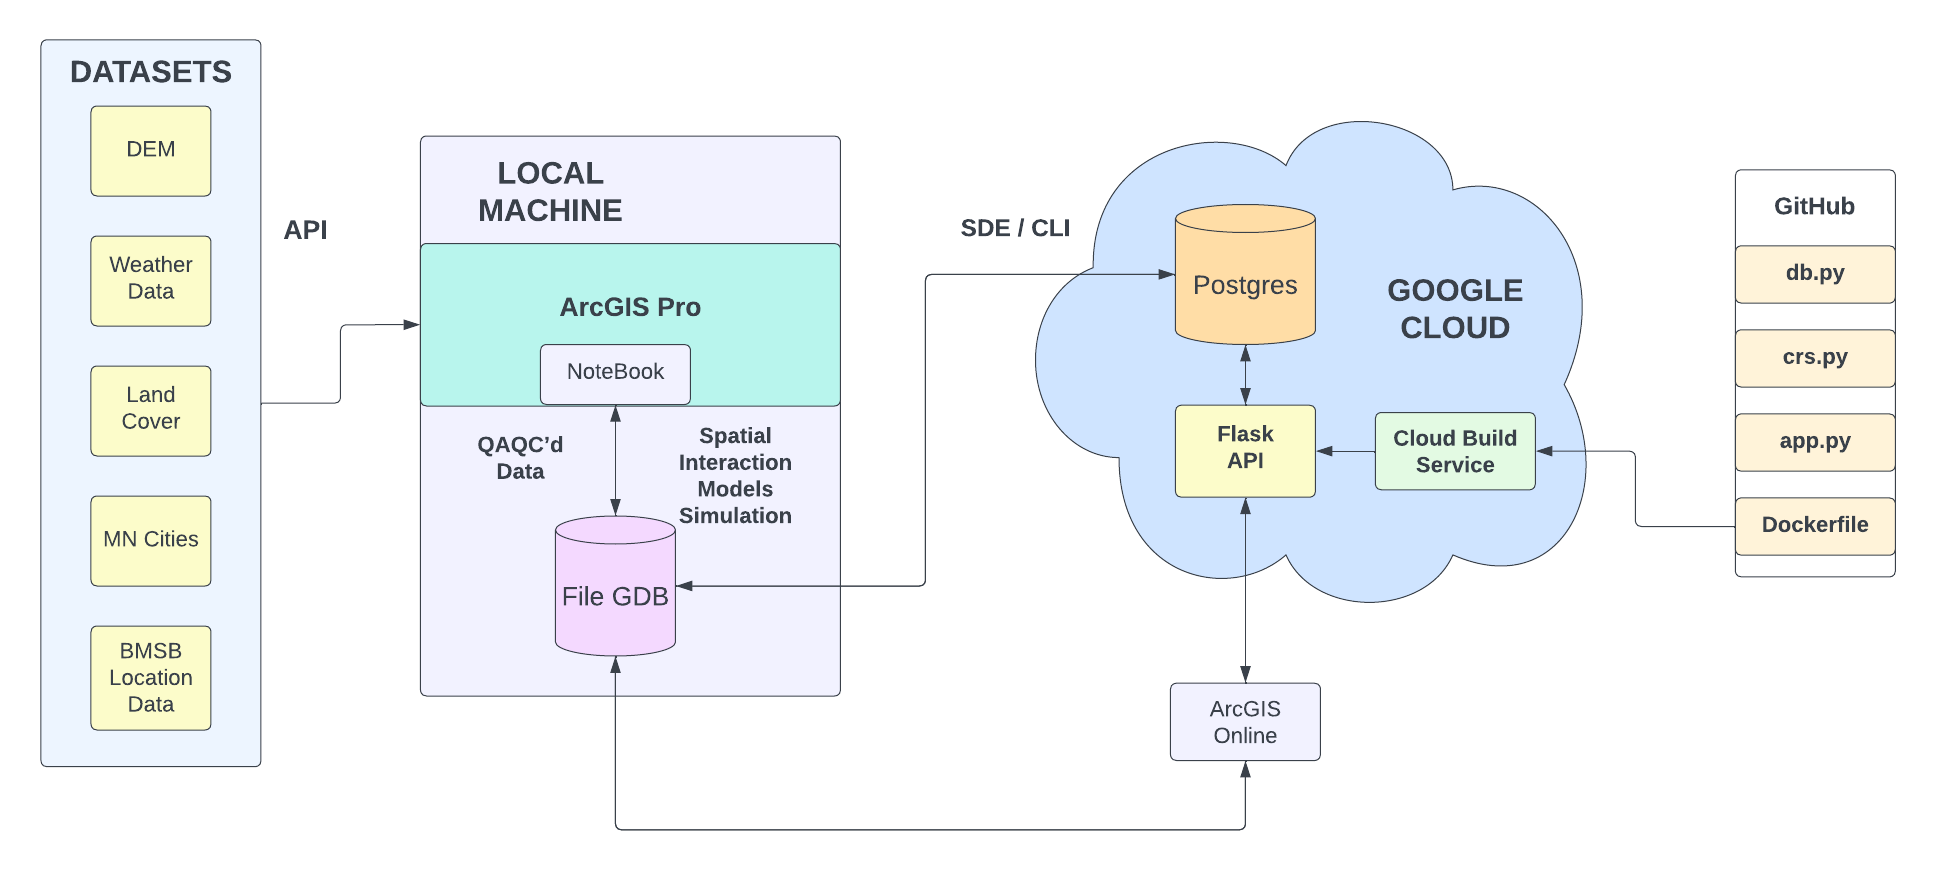

In [109]:
# Set the path to the image file
image_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Deliverables\System Architecture.png"

# Display the image
Image(image_path)

#### Import All Required Modules for this Lab

In [110]:
# Library for data manipulation and analysis
import pandas as pd

# Library for working with ArcGIS tools and functionalities
import arcpy
import arcgis

# Library for handling JSON data
import json

# Library for making HTTP requests and interacting with web services
import requests

# Library for interacting with the operating system, managing file paths, and executing system commands
import os

# Library for handling warnings generated during code execution
import warnings

# Library for displaying images in Jupyter Notebooks
from IPython.display import Image

# Library for generating random numbers
import random

# Library for handling zip files and working with IO streams
import zipfile
import io

# Library for working with dates
from datetime import date

import urllib.request

### Setting Up ArcPy Environment for Geospatial Processing

In [111]:
# get the directory path of the currently open ArcGIS project
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)

# Change the current working directory to the extracted directory path
os.chdir(file_path)

# Set the workspace environment to the extracted directory path
arcpy.env.workspace = file_path

# Define a spatial reference with ID 26915 (UTM zone 15N)
spatial_ref = arcpy.SpatialReference(26915)

# Establish variables for project and map
project = arcpy.mp.ArcGISProject("CURRENT")
m = project.listMaps("Map")[0]

### Path to Local FGDB 

In [112]:
#path to local database
file_gdb = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\ArcPro Files\ArcII_Final Project\ArcII_Final Project.gdb"

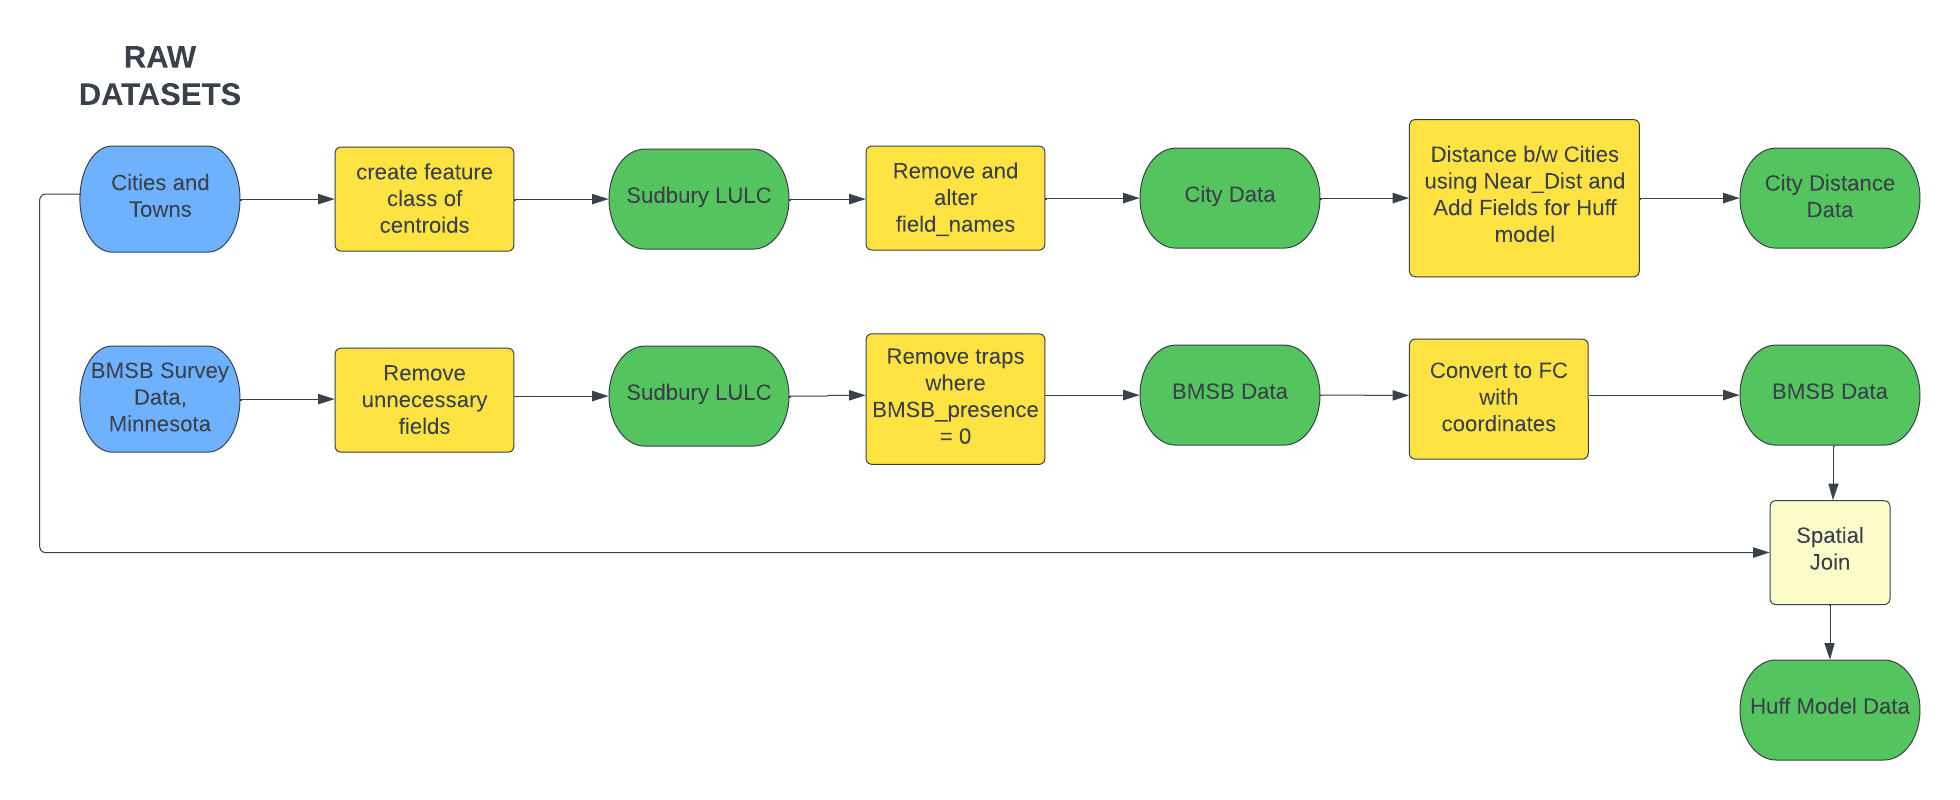

In [113]:
# Set the path to the image file
image_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Deliverables\QAQC Data Flow.png"

# Display the image
Image(image_path)

## BMSB SURVEY DATA
BMSB Survey Data, Minnesota: https://gisdata.mn.gov/it/dataset/biota-bmsb

### ETL Part to pull data from the URL

In [17]:
def mn_geo_pull_and_unzip(url, directory, GDB_or_SHP):
    try:
        api = requests.get(url)
        api.raise_for_status()  
        json_data = api.json()
        
        resources = json_data.get('result', {}).get('resources', [])
        format_url = next((resource['url'] for resource in resources if resource.get('format') == GDB_or_SHP), None)
        
        if format_url:
            zip_link = requests.get(format_url)
            z_file = zipfile.ZipFile(io.BytesIO(zip_link.content))
            z_file.extractall(directory)
            print("Data successfully extracted.")
        else:
            print(f"No '{GDB_or_SHP}' format found in the resources.")
            
    except requests.RequestException as e:
        print("Request error:", e)
    
    except Exception as e:
        print("An unexpected error occurred:", e)

In [18]:
mn_geo_pull_and_unzip('https://gisdata.mn.gov/api/3/action/package_show?id=biota-bmsb',
                      r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Data\BMSB','SHP')

Data successfully extracted.


In [19]:
# Paths
dbf_file_path = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Data\BMSB\BMSBSurveyDataTable.dbf'

# Save table as feature class in file geodatabase
arcpy.conversion.TableToTable(dbf_file_path, file_gdb, "BMSBSurveyDataTable")

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\BMSBSurveyDataTable'>

#### QAQC BMSB Population Data

In [33]:
# Path to the input file within the file geodatabase
BMSBSurveyDataTable = os.path.join(file_gdb, 'BMSBSurveyDataTable')

In [34]:
# Path to save the cleaned data as a shapefile within the file geodatabase
BMSBSurveyDataTable_Clean = os.path.join(file_gdb, 'BMSBSurveyDataTable_Clean')

In [35]:
# Fields to keep during cleaning
fields_to_keep = ['OBJECTID', 'City', 'County', 'Latitude', 'Longitude', 'Adults', 'Nymphs']

# Create dictionaries to store aggregated values by city
city_data = {}

# Open a search cursor to iterate over the input table
with arcpy.da.SearchCursor(BMSBSurveyDataTable, fields_to_keep) as cursor:
    for row in cursor:
        city = row[1]  # City name
        adults = row[5]  # Adults column
        nymphs = row[6]  # Nymphs column
        if city not in city_data:
            # If city is not in the dictionary, initialize values
            city_data[city] = {'latitude': [], 'longitude': [], 'adults': 0, 'nymphs': 0}
        # Append latitude and longitude values
        city_data[city]['latitude'].append(row[3])
        city_data[city]['longitude'].append(row[4])
        # Sum adults and nymphs
        city_data[city]['adults'] += adults
        city_data[city]['nymphs'] += nymphs

# Create a new table
arcpy.CreateTable_management(out_path=file_gdb,
                              out_name='BMSBSurveyDataTable_Clean')

# Add fields to the new table
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'City', 'TEXT')
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'Latitude', 'DOUBLE')
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'Longitude', 'DOUBLE')
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'Adults', 'LONG')
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'Nymphs', 'LONG')

# Open an insert cursor to add rows to the new table
with arcpy.da.InsertCursor(BMSBSurveyDataTable_Clean, ['City', 'Latitude', 'Longitude', 'Adults', 'Nymphs']) as cursor:
    # Iterate over the city data dictionary
    for city, data in city_data.items():
        # Calculate mean latitude and longitude
        mean_latitude = sum(data['latitude']) / len(data['latitude'])
        mean_longitude = sum(data['longitude']) / len(data['longitude'])
        # Insert row into the new table
        cursor.insertRow([city, mean_latitude, mean_longitude, data['adults'], data['nymphs']])

print("Data cleaned and saved to output table.")

Data cleaned and saved to output table.


In [36]:
# Add new fields 'BMSB_Total' and 'BMSB_presence' to the cleaned standalone table
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'BMSB_Total', 'LONG')
arcpy.AddField_management(BMSBSurveyDataTable_Clean, 'BMSB_presence', 'SHORT')

# Open an update cursor to iterate over the table
with arcpy.da.UpdateCursor(BMSBSurveyDataTable_Clean, ['Adults', 'Nymphs', 'BMSB_Total', 'BMSB_presence']) as cursor:
    for row in cursor:
        # Calculate BMSB_Total as the sum of Adults and Nymphs
        row[2] = row[0] + row[1]
        
        # Check if either 'Adults' or 'Nymphs' is greater than 0
        if row[0] > 0 or row[1] > 0:
            # If either condition is true, set 'BMSB_presence' to 1
            row[3] = 1
        else:
            # Otherwise, set 'BMSB_presence' to 0
            row[3] = 0
        # Update the row
        cursor.updateRow(row)

print(f"New fields 'BMSB_Total' and 'BMSB_presence' added successfully to: {BMSBSurveyDataTable_Clean}")

New fields 'BMSB_Total' and 'BMSB_presence' added successfully to: F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\ArcPro Files\ArcII_Final Project\ArcII_Final Project.gdb\BMSBSurveyDataTable_Clean


#### CONVERT TABLE TO FEATURE LAYER:

In [114]:
# Convert table to point feature class
arcpy.management.XYTableToPoint(
    in_table=os.path.join(file_gdb,'BMSBSurveyDataTable_Clean'),
    out_feature_class=os.path.join(file_gdb,'BMSB_Sightings'),
    x_field="Longitude",
    y_field="Latitude",
    z_field=None,
    coordinate_system=spatial_ref
)

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\BMSB_Sightings'>

##### Get just the Cities with BMSB presence

In [115]:
BMSBData_Clean = os.path.join(file_gdb, "BMSB_Sightings")

# Load Cities to GDB
arcpy.conversion.ExportFeatures(
    BMSBData_Clean,
    os.path.join(file_gdb, "BMSBDataClean_Filtered"),
    where_clause="BMSB_presence > 0",
)

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\BMSBDataClean_Filtered'>

## MINNESOTA CITIES DATA

In [118]:
# Define a function to pull data from the Minnesota Geospatial Commons
def mn_geo_pull_and_unzip(url, directory, GDB_or_SHP):

    # Get GeoJSON from MN Geospatial Commons
    api = requests.get(url)
    json = api.json()
    
    # Use second list in the 'resources' key if data is in file geodatabase format
    if GDB_or_SHP == 'GDB':
        zip_link = requests.get(json['result']['resources'][1]['url'])
    
    # Use first list in the 'resources' key if data is in shapefile format
    if GDB_or_SHP == 'SHP':
        zip_link = requests.get(json['result']['resources'][2]['url'])
    
    # Get zipfile and extract
    z_file = zipfile.ZipFile(io.BytesIO(zip_link.content))
    z_file.extractall(directory)

In [119]:
mn_geo_pull_and_unzip('https://gisdata.mn.gov/api/3/action/package_show?id=bdry-mn-city-township-unorg',
                      r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Data\MN Cities','GDB')

In [120]:
# Paths
layer_file_path = r'F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Data\MN Cities\City, Township, Unorganized Territory Boundaries, Minnesota.lyr'

# Save layer as feature class in file geodatabase
arcpy.conversion.FeatureClassToFeatureClass(layer_file_path, file_gdb, "MN_CTUs")

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\MN_CTUs'>

### Just get the Cities in MN and Clean City Population Data
* Some cities were repeatative - used dissolve tool to get unique city polygons - population was summed

In [123]:
# Paths
MN_CTUs = os.path.join(file_gdb, "MN_CTUs")
MN_Cities = os.path.join(file_gdb, "MN_Cities")

In [124]:
# Load Cities to GDB with filtering
arcpy.conversion.ExportFeatures(
    MN_CTUs,
    MN_Cities,
    where_clause="CTU_CLASS = 'CITY'",
)

# Define fields to drop and rename
fields_to_drop = ["GNIS_FEATURE_ID", "CTU_CLASS", "COUNTY_GNIS_FEATURE_ID", "COUNTY_CODE", "COUNTY_NAME"]

# Drop specified fields
fields_to_keep = [f.name for f in arcpy.ListFields(MN_Cities) if f.type not in ["OID", "Geometry"]]
fields_to_drop = [field for field in fields_to_drop if field in fields_to_keep]
arcpy.management.DeleteField(MN_Cities, fields_to_drop)

# Rename FEATURE_NAME to City and set alias
arcpy.management.AlterField(MN_Cities, "FEATURE_NAME", "City", "City")

print("Fields modified successfully in MN_Cities.")

# Dissolve cities where they repeat and sum their populations
output_dissolved = os.path.join(file_gdb, "MN_Cities_Dissolved")
arcpy.management.Dissolve(MN_Cities, output_dissolved, "City", statistics_fields=[["Population", "SUM"]], multi_part="MULTI_PART", unsplit_lines="UNSPLIT_LINES")

print("City polygons dissolved successfully and populations summed.")

Fields modified successfully in MN_Cities.
City polygons dissolved successfully and populations summed.


## HUFF MODEL DATA PREPARATION

### Calculating Distance between Cities Table

* This is a standalone table
* Attractiveness is population of each city and distance between between City_A to City_B

In [25]:
# Define file paths
MN_Cities_Dis = os.path.join(file_gdb, "MN_Cities_Dissolved")
output_table = os.path.join(file_gdb, "MN_Cities_Distance_Table")

In [26]:
# Create a new table
arcpy.management.CreateTable(os.path.dirname(output_table), os.path.basename(output_table))

# Add fields to the output table
arcpy.management.AddField(output_table, "City_1", "TEXT")
arcpy.management.AddField(output_table, "City_2", "TEXT")
arcpy.management.AddField(output_table, "Near_Dist", "DOUBLE")  # Moved Near_Dist to 3rd position
arcpy.management.AddField(output_table, "City_1_POP", "LONG")
arcpy.management.AddField(output_table, "City_2_POP", "LONG")
arcpy.management.AddField(output_table, "Trans_Prob_15", "DOUBLE")
arcpy.management.AddField(output_table, "Trans_Prob_175", "DOUBLE")
arcpy.management.AddField(output_table, "Trans_Prob_2", "DOUBLE")

# Generate a cursor to insert rows into the output table
with arcpy.da.InsertCursor(output_table, ["City_1", "City_2", "Near_Dist", "City_1_POP", "City_2_POP"]) as cursor:
    inserted_pairs = set()  # Set to keep track of inserted pairs
    # Iterate over each city as City_1
    with arcpy.da.SearchCursor(MN_Cities_Dis, ["City", "SUM_Population", "SHAPE@XY"]) as city1_cursor:
        for city1_row in city1_cursor:
            city1_name, city1_pop, city1_xy = city1_row[0], city1_row[1], city1_row[2]
            # Iterate over each city as City_2
            with arcpy.da.SearchCursor(MN_Cities_Dis, ["City", "SUM_Population", "SHAPE@XY"]) as city2_cursor:
                for city2_row in city2_cursor:
                    city2_name, city2_pop, city2_xy = city2_row[0], city2_row[1], city2_row[2]
                    # Check if City_1 and City_2 are different and not already inserted
                    if city1_name != city2_name and (city2_name, city1_name) not in inserted_pairs:
                        # Calculate distance between City_1 and City_2
                        x1, y1 = city1_xy
                        x2, y2 = city2_xy
                        near_dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                        # Insert row into output table
                        cursor.insertRow([city1_name, city2_name, near_dist, city1_pop, city2_pop])
                        # Add the inserted pair to the set
                        inserted_pairs.add((city1_name, city2_name))

print("City distance table created successfully.")

City distance table created successfully.


### Cities Layer to Points

In [18]:
# Define file paths
MN_Cities_Dis = os.path.join(file_gdb, "MN_Cities_Dissolved")
MN_Cities_Pts = os.path.join(file_gdb, "MN_Cities_Pts")
MN_Cities_15 = os.path.join(file_gdb, "MN_Cities_15")

In [19]:
# Convert MN_Cities_Dis to points
arcpy.management.FeatureToPoint(in_features=MN_Cities_Dis, out_feature_class=MN_Cities_Pts, point_location="CENTROID")
arcpy.management.FeatureToPoint(in_features=MN_Cities_Dis, out_feature_class=MN_Cities_15, point_location="CENTROID")

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\MN_Cities_15'>

#### Appending Cities Point Layer

In [20]:
# Add new columns in MN_Cities_Pts
for i in range(100):
    fieldname = 'BMSB_Sim' + str(i)
    arcpy.management.AddField(MN_Cities_15, fieldname, "SHORT")

# Add more columns in MN_Cities_Pts
col_list = ["TP", "TN", "FP", "FN", "Presence", "Accuracy", "Rank"]
for col in col_list:
    arcpy.management.AddField(MN_Cities_15, col, "DOUBLE")

print("Columns added successfully to MN_Cities_15.")

Columns added successfully to MN_Cities_15.


In [21]:
# Add tables for alpha values of 1.75 and 2
table_list = ['MN_Cities_175', 'MN_Cities_2']


for table in table_list:
    out_feature_class = os.path.join(file_gdb, table)
    print("Copying features as:", out_feature_class)
    arcpy.management.CopyFeatures(
        in_features='MN_Cities_15',
        out_feature_class=out_feature_class
    )

Copying features as: F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\ArcPro Files\ArcII_Final Project\ArcII_Final Project.gdb\MN_Cities_175
Copying features as: F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\ArcPro Files\ArcII_Final Project\ArcII_Final Project.gdb\MN_Cities_2


### Spatial Join between BMSB and City Population

In [64]:
# Define file paths
targetFeatures = os.path.join(file_gdb, "BMSB_Sightings")
joinFeatures = os.path.join(file_gdb, "MN_Cities_Dissolved")
BMSB_PointsData_SJ = os.path.join(file_gdb, "BMSB_PointsData_SJ") 

In [65]:
# Perform spatial join
arcpy.analysis.SpatialJoin(targetFeatures, joinFeatures, BMSB_PointsData_SJ, "#", "#", match_option="CLOSEST_GEODESIC")

<Result 'F:\\1. UMN MGIS\\1. Semesters\\4th Semester\\1. ArcGIS II\\4. Project\\ArcPro Files\\ArcII_Final Project\\ArcII_Final Project.gdb\\BMSB_PointsData_SJ'>